In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings("ignore")

In [2]:
grid = xr.open_dataset('/data1/parker/LO_data/grids/cas7/grid.nc')

In [3]:
ctd2013 = pd.read_pickle('/data1/bbeutel/LO_output/obsmod/cas7_t0_x4b/multi_ctd_2013.p')
ctd2014 = pd.read_pickle('/data1/bbeutel/LO_output/obsmod/cas7_t0_x4b/multi_ctd_2014.p')
ctd2015 = pd.read_pickle('/data1/bbeutel/LO_output/obsmod/cas7_t0_x4b/multi_ctd_2015.p')
ctd2016 = pd.read_pickle('/data1/bbeutel/LO_output/obsmod/cas7_t0_x4b/multi_ctd_2016.p')
ctd2017 = pd.read_pickle('/data1/bbeutel/LO_output/obsmod/cas7_t0_x4b/multi_ctd_2017.p')
ctd2018 = pd.read_pickle('/data1/bbeutel/LO_output/obsmod/cas7_t0_x4b/multi_ctd_2018.p')
ctd2019 = pd.read_pickle('/data1/bbeutel/LO_output/obsmod/cas7_t0_x4b/multi_ctd_2019.p')


In [4]:
bot2013 = pd.read_pickle('/data1/bbeutel/LO_output/obsmod/cas7_t0_x4b/multi_bottle_2013.p')
bot2014 = pd.read_pickle('/data1/bbeutel/LO_output/obsmod/cas7_t0_x4b/multi_bottle_2014.p')
bot2015 = pd.read_pickle('/data1/bbeutel/LO_output/obsmod/cas7_t0_x4b/multi_bottle_2015.p')
bot2016 = pd.read_pickle('/data1/bbeutel/LO_output/obsmod/cas7_t0_x4b/multi_bottle_2016.p')
bot2017 = pd.read_pickle('/data1/bbeutel/LO_output/obsmod/cas7_t0_x4b/multi_bottle_2017.p')
bot2018 = pd.read_pickle('/data1/bbeutel/LO_output/obsmod/cas7_t0_x4b/multi_bottle_2018.p')
bot2019 = pd.read_pickle('/data1/bbeutel/LO_output/obsmod/cas7_t0_x4b/multi_bottle_2019.p')


In [5]:
obs = pd.concat([bot2013['obs'], bot2014['obs'], bot2015['obs'], bot2016['obs'], bot2017['obs'], bot2018['obs'], bot2019['obs']], ignore_index=True)
obs.name = 'bottle' # so that we can differentiate between bottle and ctd casts from dfo just in case
obs = pd.concat([obs,ctd2013['obs'], ctd2014['obs'], ctd2015['obs'], ctd2016['obs'], ctd2017['obs'], ctd2018['obs'], ctd2019['obs']], ignore_index=True)
obs.head()

,cid,lon,lat,time,z,SA,CT,DO (uM),NO3 (uM),Chl (mg m-3),name,cruise,source,NO2 (uM),NH4 (uM),PO4 (uM),SiO4 (uM),TA (uM),DIC (uM)
0,0.0,-123.500336,48.593334,2013-02-06 03:32:28,-4.858567,29.526436,8.481087,217.480499,NaN,NaN,bottle,NaN,dfo1,NaN,NaN,NaN,NaN,NaN,NaN
1,0.0,-123.500336,48.593334,2013-02-06 03:32:28,-25.084826,29.931217,8.744595,194.705338,NaN,NaN,bottle,NaN,dfo1,NaN,NaN,NaN,NaN,NaN,NaN
2,0.0,-123.500336,48.593334,2013-02-06 03:32:28,-49.770050,30.161832,8.232655,199.617615,NaN,NaN,bottle,NaN,dfo1,NaN,NaN,NaN,NaN,NaN,NaN
3,0.0,-123.500336,48.593334,2013-02-06 03:32:28,-99.627083,31.185733,9.074455,7.145150,NaN,NaN,bottle,NaN,dfo1,NaN,NaN,NaN,NaN,NaN,NaN
4,0.0,-123.500336,48.593334,2013-02-06 03:32:28,-148.778397,31.455940,9.045912,5.805434,NaN,NaN,bottle,NaN,dfo1,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
# remove all unreasonable DO values, based on calculated max DO
obs.loc[obs['DO (uM)'] > 475, 'DO (uM)'] = pd.NA

# remove negative NO3 and Chl
obs.loc[obs['NO3 (uM)'] < 0, 'NO3 (uM)'] = pd.NA
obs.loc[obs['Chl (mg m-3)'] < 0, 'Chl (mg m-3)'] = pd.NA

# remove unresonable salinities
obs.loc[obs['SA'] > 40, 'SA'] = pd.NA


Text(0, 0.5, 'Monthly count')

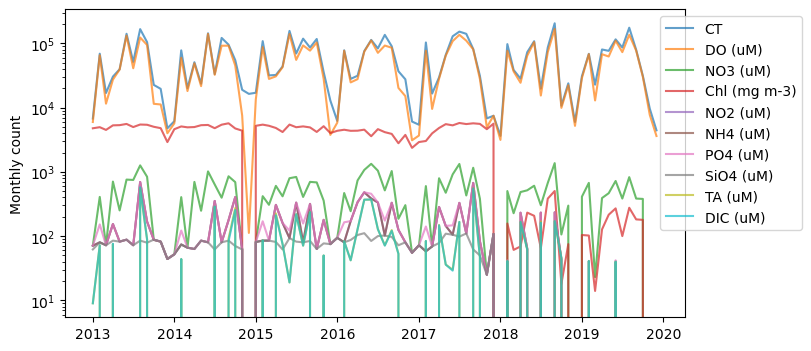

In [7]:
# lets see how the count of data changes with time, seperated by what was measured
# Extract both month and year from the 'time' column
obs['year_month'] = obs['time'].dt.to_period('M')  # This creates a Period object 'YYYY-MM'
obs['year_month'] = obs['year_month'].dt.to_timestamp()

# Columns to count non-NaN entries
columns_to_count = [
    'SA', 'CT', 'DO (uM)', 'NO3 (uM)', 'Chl (mg m-3)', 'NO2 (uM)', 
    'NH4 (uM)', 'PO4 (uM)', 'SiO4 (uM)', 'TA (uM)', 'DIC (uM)'
]

# Group by 'year_month' and count non-NaN entries for each column
monthly_counts = obs.groupby('year_month')[columns_to_count].count()

# plot
fig, ax = plt.subplots(1,1,figsize=[8,4])

for var in monthly_counts.columns[1:]:
    ax.plot(monthly_counts.index, monthly_counts[var], label=var,alpha=0.7)

ax.set_yscale('log')
ax.legend(bbox_to_anchor=(1.2, 1.0))
ax.set_ylabel('Monthly count')


## remove salish sea points (too many of the clusters delineating within there)

In [8]:
ny = 49.2
sy = 47.4
d = 2000

# from evaluations code where i separate into regions
ind = np.where((obs.lon > np.sqrt((1-(((obs.lat-42)**2)/(10**2)))*(7**2))-130) & (obs.lat < 51)) 
obs = obs.drop(ind[0])
obs.reset_index(drop=True, inplace=True)

In [12]:
    def cluster(key):
        # Drop rows with NaN values in the 'salinity' column
        df_clean = obs.dropna(subset=[key])

        # Selecting the property to cluster
        X = df_clean[[key]].values

        # Applying K-means clustering
        kmeans = KMeans(n_clusters=5, random_state=0).fit(X)

        # Assign the cluster labels back to the DataFrame
        df_clean['Cluster'] = kmeans.labels_

        return df_clean[['time','lon','lat','z',key,'Cluster']]
    
    def cluster_plot(df_clean, key):
        # Plotting clusters
        plt.figure(figsize=(9,4)) 
        ax0 = plt.subplot(131)
        ax1 = plt.subplot(132)
        ax2 = plt.subplot(133, projection='3d')

        for cluster in range(len(df_clean['Cluster'].unique())):
            cluster_data = df_clean[df_clean['Cluster'] == cluster]
            ax0.scatter(cluster_data[key], cluster_data['z'], s=3, label=f'Cluster {cluster}')
            ax1.scatter(cluster_data['lon'], cluster_data['lat'], alpha=0.2, s=3, label=f'Cluster {cluster}')
            ax2.scatter(cluster_data['lon'], cluster_data['lat'], cluster_data['z'], zdir='z', s=2, alpha=0.2, depthshade=True)

        ax0.set_ylabel('Depth (m)')
        ax0.set_xlabel(key)
        ax0.set_title(key+' Clusters')
        ax0.legend()
        ax0.set_ylim([-4000,0])


        ax1.contourf(grid.lon_rho, grid.lat_rho, grid.mask_rho, linewidths=1, levels=[-0.01, 0.01], colors='whitesmoke')
        ax1.contour(grid.lon_rho, grid.lat_rho, grid.mask_rho, linewidths=1, levels=[-0.01, 0.01], colors='dimgray')
        ax1.contour(grid.lon_rho, grid.lat_rho,grid.h, linewidths=1, levels=[200, 1000, 2000], colors='dimgray', alpha=0.5)
        ax1.set_ylabel('Latitude')
        ax1.set_xlabel('Longitude')
        ax1.set_ylim([42,52])
        ax1.set_xlim([-130,-122])

        plt.tight_layout()

    def ind_cluster_plots(data, n, ax, colour):
        
        cluster_data = data[data['Cluster'] == n]
        ax.scatter(cluster_data['lon'], cluster_data['lat'], color=colour, alpha=0.8, s=3, label=f'Cluster {n}')

        ax.contourf(grid.lon_rho, grid.lat_rho, grid.mask_rho, linewidths=1, levels=[-0.01, 0.01], colors='whitesmoke')
        ax.contour(grid.lon_rho, grid.lat_rho, grid.mask_rho, linewidths=1, levels=[-0.01, 0.01], colors='dimgray')
        ax.contour(grid.lon_rho, grid.lat_rho,grid.h, linewidths=1, levels=[200, 1000, 2000], colors='dimgray', alpha=0.5)
        ax.set_ylabel('Latitude')
        ax.set_xlabel('Longitude')
        ax.set_ylim([42,52])
        ax.set_xlim([-130,-122])

        title = 'cluster '+str(n)+': '+str(len(cluster_data))
        ax.set_title(n)

        plt.tight_layout()

In [10]:
colours = ['tab:blue','tab:orange','tab:green','tab:red','tab:purple']

Text(0, 0.5, 'Fraction of Count')

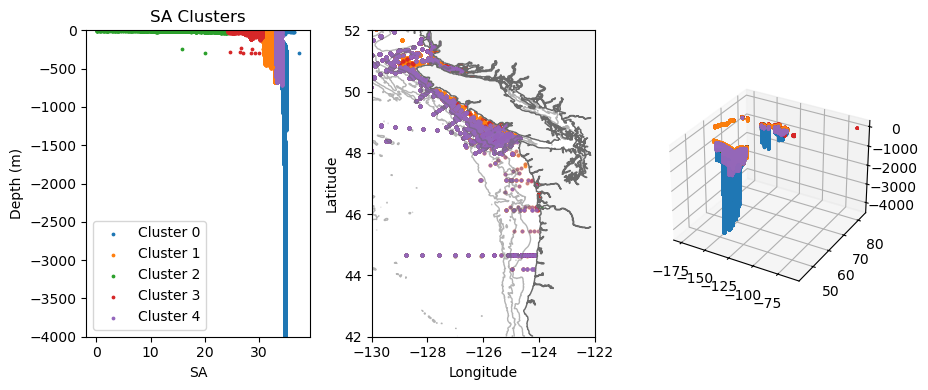

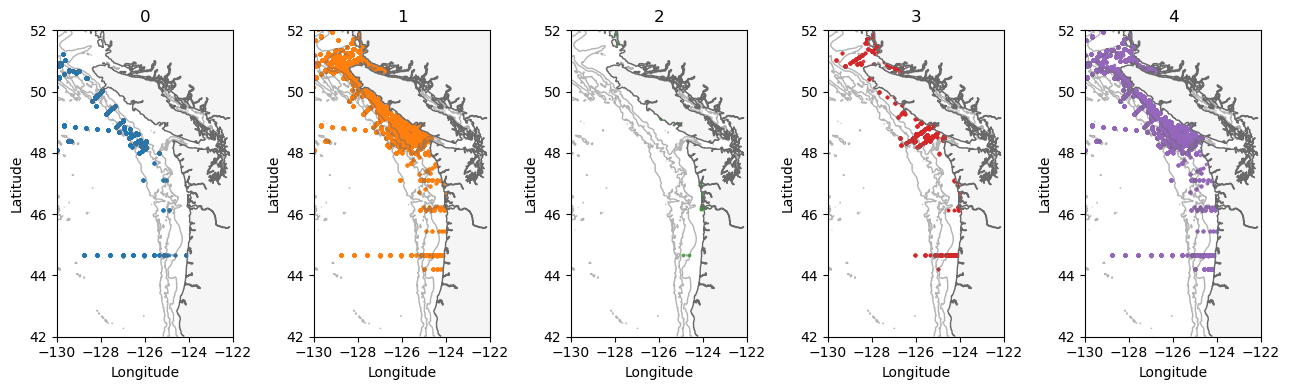

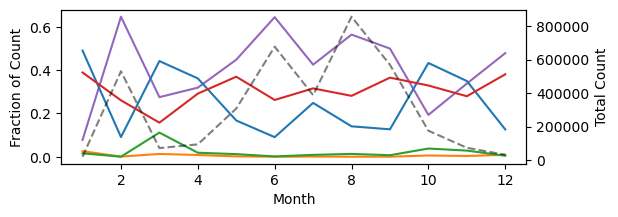

In [13]:
SAcluster = cluster('SA')
cluster_plot(SAcluster, "SA")

fig, ax = plt.subplots(1,5,figsize=[13,4])
for n in range(5):
    ind_cluster_plots(SAcluster, n, ax[n], colours[n])

# should add plot that shows clusters in time versus depth
Cdata = SAcluster
Cdata['month']=[Cdata.time[i].month for i in Cdata.index]

ntot = [len(Cdata[(Cdata.month==mo)]) for mo in np.arange(1,13)] # montly total count

fig,ax = plt.subplots(1,1,figsize=[6,2])
for k in range(len(Cdata['Cluster'].unique())):
    ax.plot(np.arange(1,13), [len(Cdata[(Cdata.Cluster==k) & (Cdata.month==mo)])/(ntot[mo-1]+1) for mo in np.arange(1,13)], c=colours[k-1])
ax2 = ax.twinx()
ax2.plot(np.arange(1,13),ntot,'k--',alpha=0.5)

ax2.set_ylabel('Total Count')
ax.set_xlabel('Month')
ax.set_ylabel('Fraction of Count')

Text(0, 0.5, 'Fraction of Count')

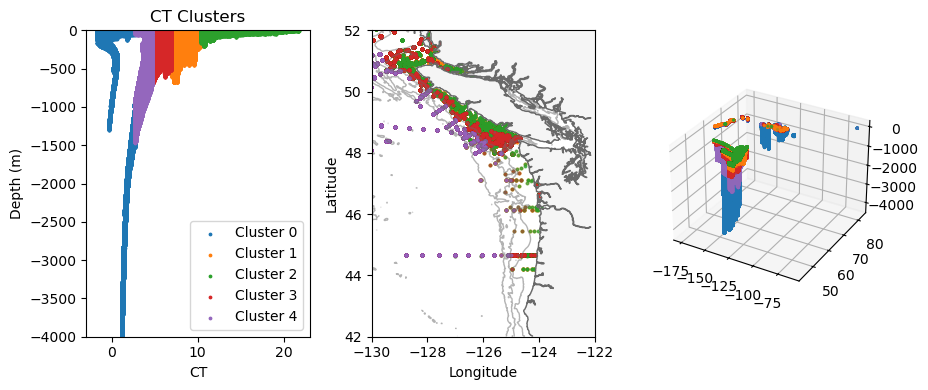

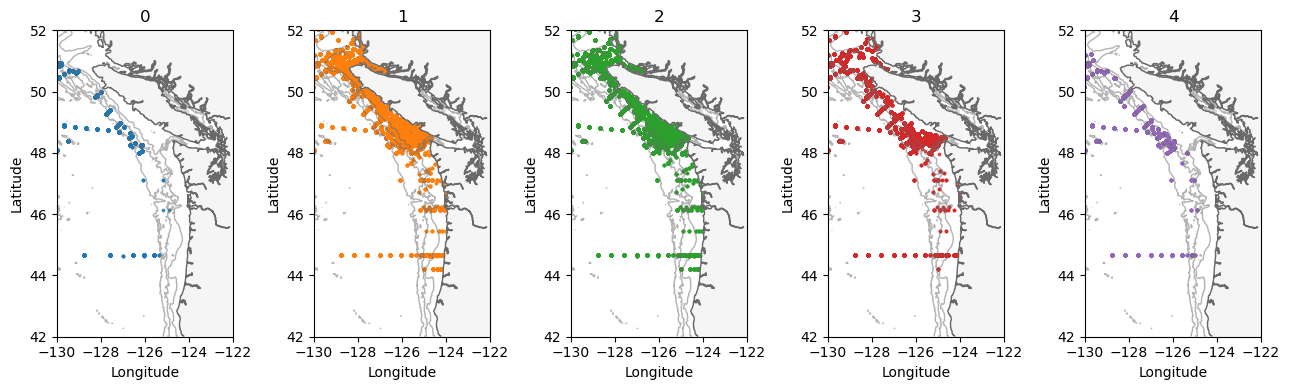

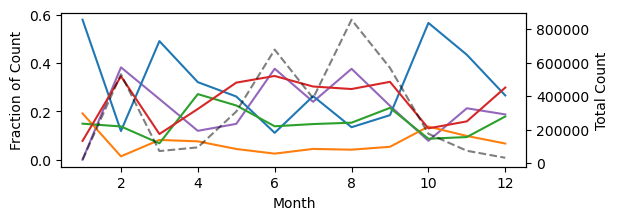

In [14]:
CTcluster = cluster('CT')
cluster_plot(CTcluster, "CT")

fig, ax = plt.subplots(1,5,figsize=[13,4])
for n in range(5):
    ind_cluster_plots(CTcluster, n, ax[n], colours[n])

# should add plot that shows clusters in time versus depth
Cdata = CTcluster
Cdata['month']=[Cdata.time[i].month for i in Cdata.index]

ntot = [len(Cdata[(Cdata.month==mo)]) for mo in np.arange(1,13)] # montly total count

fig,ax = plt.subplots(1,1,figsize=[6,2])
for k in range(len(Cdata['Cluster'].unique())):
    ax.plot(np.arange(1,13), [len(Cdata[(Cdata.Cluster==k) & (Cdata.month==mo)])/(ntot[mo-1]+1) for mo in np.arange(1,13)], c=colours[k-1])
ax2 = ax.twinx()
ax2.plot(np.arange(1,13),ntot,'k--',alpha=0.5)

ax2.set_ylabel('Total Count')
ax.set_xlabel('Month')
ax.set_ylabel('Fraction of Count')

Text(0, 0.5, 'Fraction of Count')

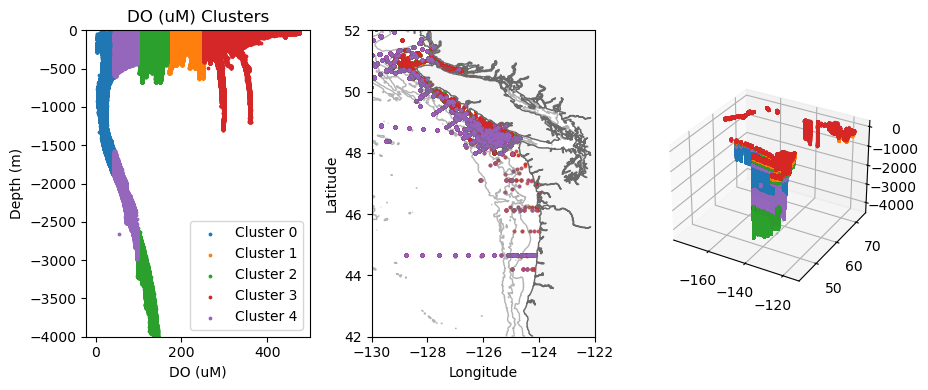

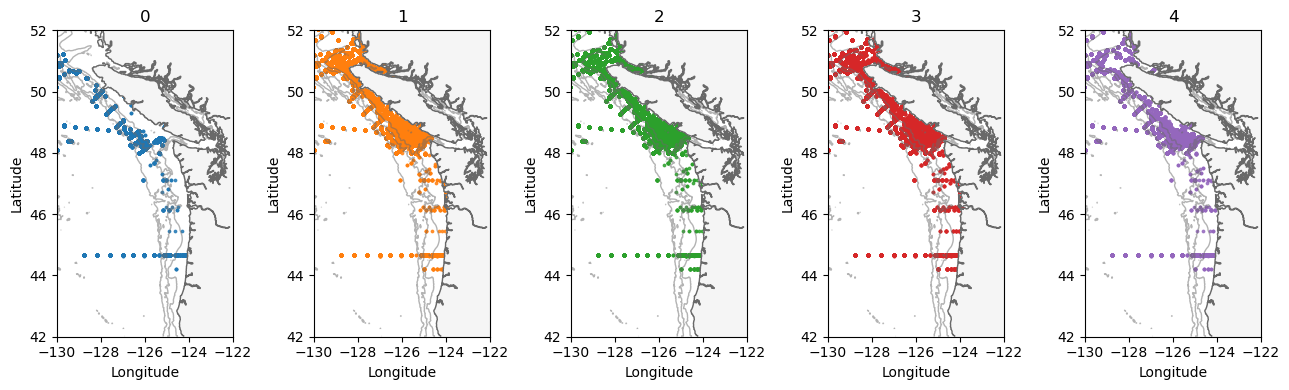

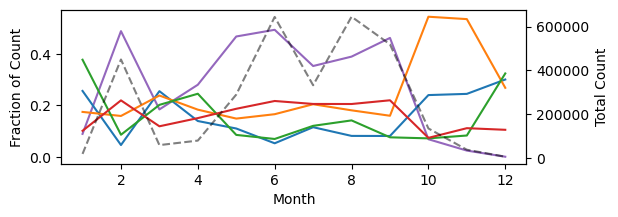

In [15]:
DOcluster = cluster('DO (uM)')
cluster_plot(DOcluster, "DO (uM)")

fig, ax = plt.subplots(1,5,figsize=[13,4])
for n in range(5):
    ind_cluster_plots(DOcluster, n, ax[n], colours[n])

# should add plot that shows clusters in time versus depth
Cdata = DOcluster
Cdata['month']=[Cdata.time[i].month for i in Cdata.index]

ntot = [len(Cdata[(Cdata.month==mo)]) for mo in np.arange(1,13)] # montly total count

fig,ax = plt.subplots(1,1,figsize=[6,2])
for k in range(len(Cdata['Cluster'].unique())):
    ax.plot(np.arange(1,13), [len(Cdata[(Cdata.Cluster==k) & (Cdata.month==mo)])/(ntot[mo-1]+1) for mo in np.arange(1,13)], c=colours[k-1])
ax2 = ax.twinx()
ax2.plot(np.arange(1,13),ntot,'k--',alpha=0.5)

ax2.set_ylabel('Total Count')
ax.set_xlabel('Month')
ax.set_ylabel('Fraction of Count')

Text(0, 0.5, 'Fraction of Count')

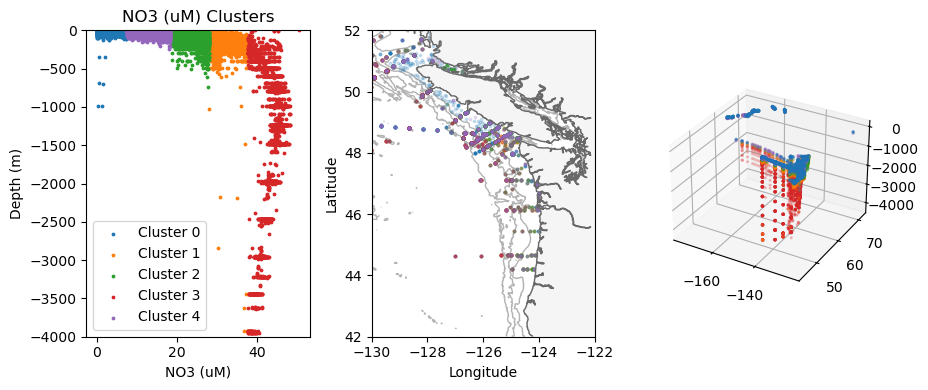

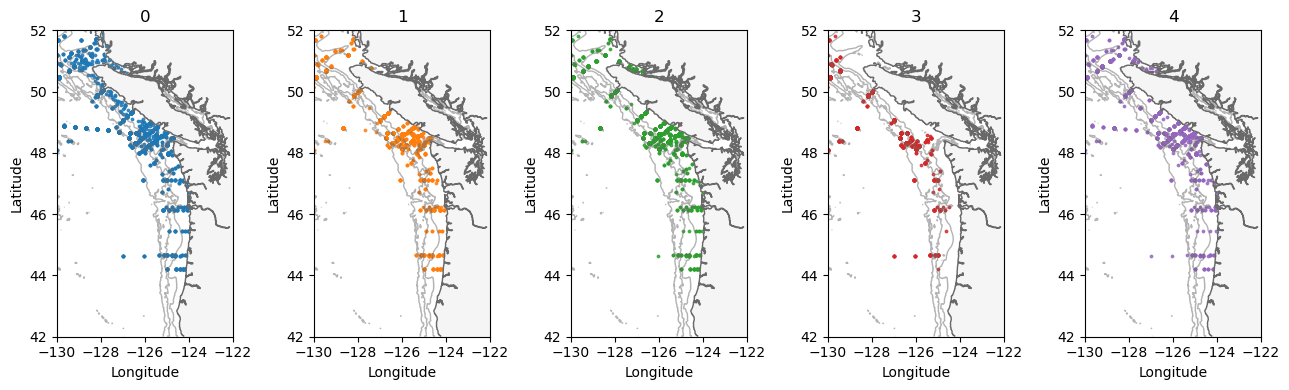

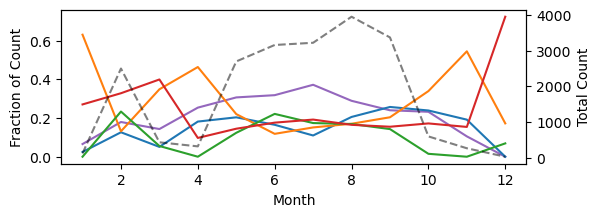

In [16]:
NO3cluster = cluster('NO3 (uM)')
cluster_plot(NO3cluster, "NO3 (uM)")

fig, ax = plt.subplots(1,5,figsize=[13,4])
for n in range(5):
    ind_cluster_plots(NO3cluster, n, ax[n], colours[n])

# should add plot that shows clusters in time versus depth
Cdata = NO3cluster
Cdata['month']=[Cdata.time[i].month for i in Cdata.index]

ntot = [len(Cdata[(Cdata.month==mo)]) for mo in np.arange(1,13)] # montly total count

fig,ax = plt.subplots(1,1,figsize=[6,2])
for k in range(len(Cdata['Cluster'].unique())):
    ax.plot(np.arange(1,13), [len(Cdata[(Cdata.Cluster==k) & (Cdata.month==mo)])/(ntot[mo-1]+1) for mo in np.arange(1,13)], c=colours[k-1])
ax2 = ax.twinx()
ax2.plot(np.arange(1,13),ntot,'k--',alpha=0.5)

ax2.set_ylabel('Total Count')
ax.set_xlabel('Month')
ax.set_ylabel('Fraction of Count')

Text(0, 0.5, 'Fraction of Count')

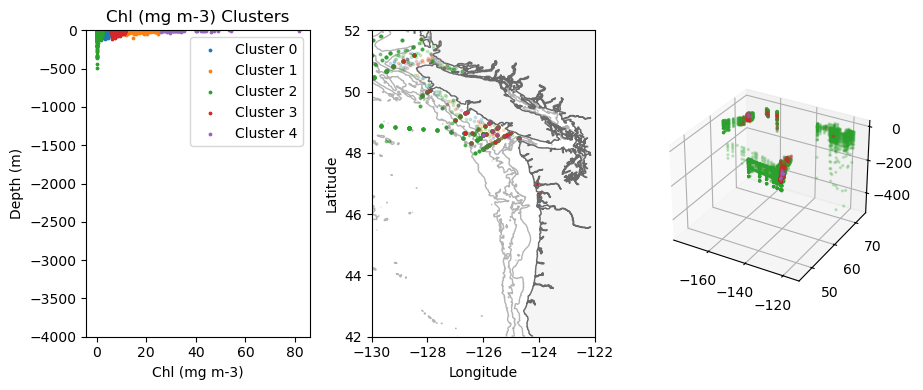

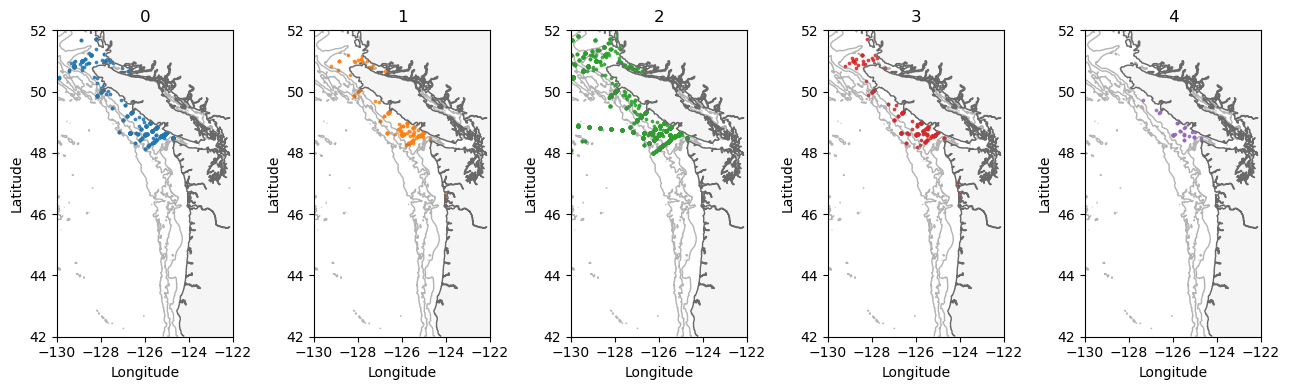

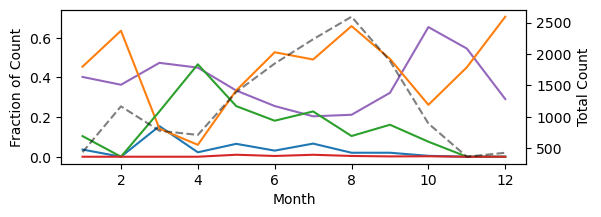

In [17]:
Chlcluster = cluster('Chl (mg m-3)')
cluster_plot(Chlcluster, "Chl (mg m-3)")

fig, ax = plt.subplots(1,5,figsize=[13,4])
for n in range(5):
    ind_cluster_plots(Chlcluster, n, ax[n], colours[n])

# should add plot that shows clusters in time versus depth
Cdata = Chlcluster
Cdata['month']=[Cdata.time[i].month for i in Cdata.index]

ntot = [len(Cdata[(Cdata.month==mo)]) for mo in np.arange(1,13)] # montly total count

fig,ax = plt.subplots(1,1,figsize=[6,2])
for k in range(len(Cdata['Cluster'].unique())):
    ax.plot(np.arange(1,13), [len(Cdata[(Cdata.Cluster==k) & (Cdata.month==mo)])/(ntot[mo-1]+1) for mo in np.arange(1,13)], c=colours[k-1])
ax2 = ax.twinx()
ax2.plot(np.arange(1,13),ntot,'k--',alpha=0.5)

ax2.set_ylabel('Total Count')
ax.set_xlabel('Month')
ax.set_ylabel('Fraction of Count')

Text(0, 0.5, 'Fraction of Count')

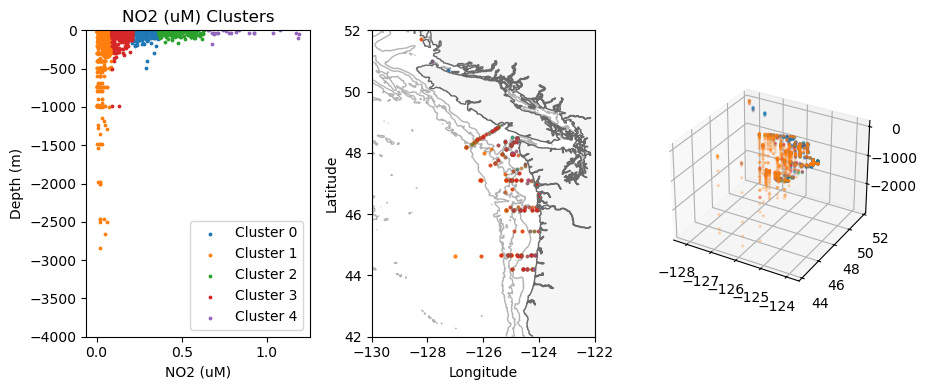

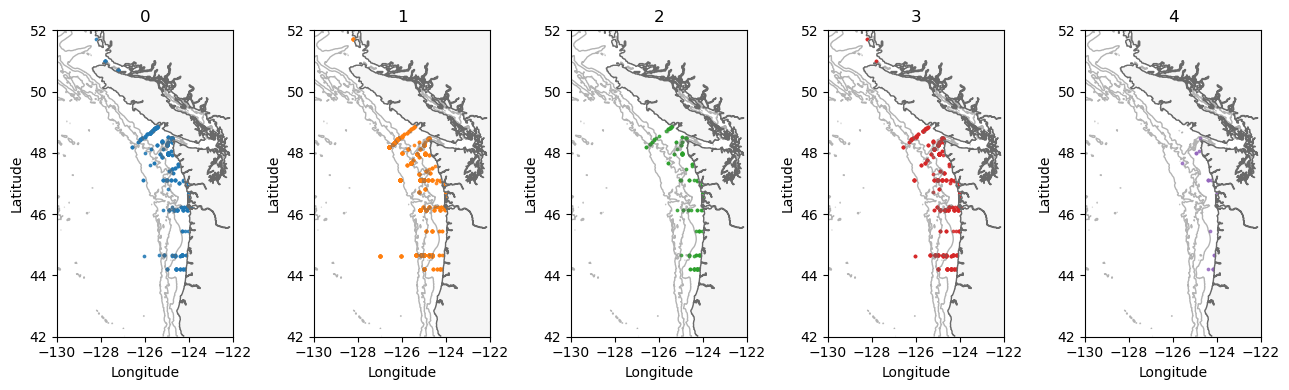

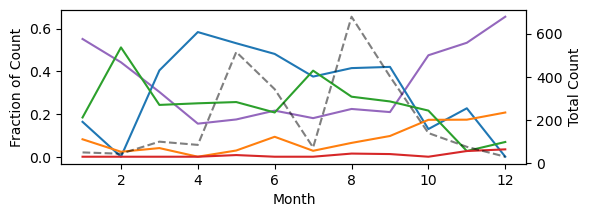

In [18]:
NO2cluster = cluster('NO2 (uM)')
cluster_plot(NO2cluster, "NO2 (uM)")

fig, ax = plt.subplots(1,5,figsize=[13,4])
for n in range(5):
    ind_cluster_plots(NO2cluster, n, ax[n], colours[n])

# should add plot that shows clusters in time versus depth
Cdata = NO2cluster
Cdata['month']=[Cdata.time[i].month for i in Cdata.index]

ntot = [len(Cdata[(Cdata.month==mo)]) for mo in np.arange(1,13)] # montly total count

fig,ax = plt.subplots(1,1,figsize=[6,2])
for k in range(len(Cdata['Cluster'].unique())):
    ax.plot(np.arange(1,13), [len(Cdata[(Cdata.Cluster==k) & (Cdata.month==mo)])/(ntot[mo-1]+1) for mo in np.arange(1,13)], c=colours[k-1])
ax2 = ax.twinx()
ax2.plot(np.arange(1,13),ntot,'k--',alpha=0.5)

ax2.set_ylabel('Total Count')
ax.set_xlabel('Month')
ax.set_ylabel('Fraction of Count')

Text(0, 0.5, 'Fraction of Count')

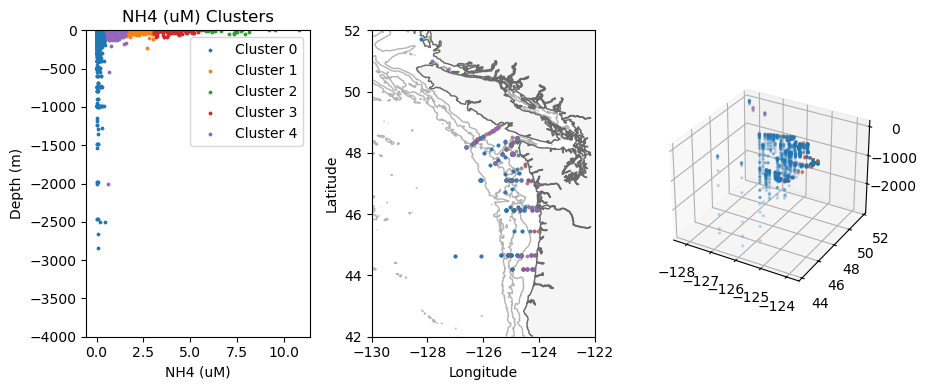

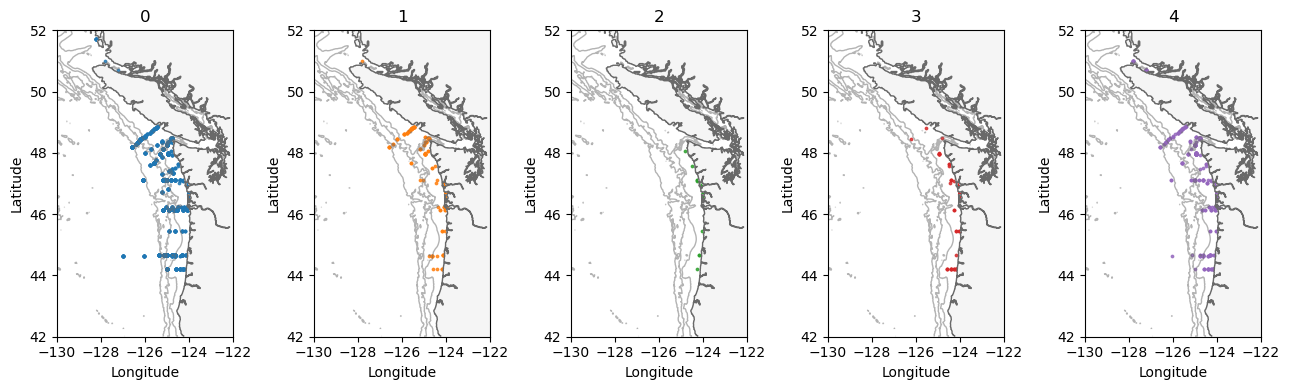

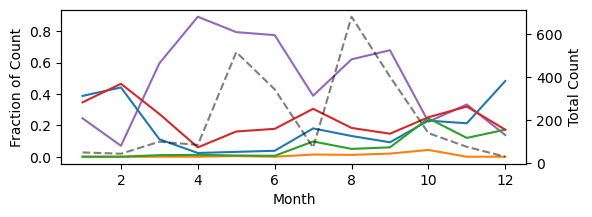

In [19]:
NH4cluster = cluster('NH4 (uM)')
cluster_plot(NH4cluster, "NH4 (uM)")

fig, ax = plt.subplots(1,5,figsize=[13,4])
for n in range(5):
    ind_cluster_plots(NH4cluster, n, ax[n], colours[n])

# should add plot that shows clusters in time versus depth
Cdata = NH4cluster
Cdata['month']=[Cdata.time[i].month for i in Cdata.index]

ntot = [len(Cdata[(Cdata.month==mo)]) for mo in np.arange(1,13)] # montly total count

fig,ax = plt.subplots(1,1,figsize=[6,2])
for k in range(len(Cdata['Cluster'].unique())):
    ax.plot(np.arange(1,13), [len(Cdata[(Cdata.Cluster==k) & (Cdata.month==mo)])/(ntot[mo-1]+1) for mo in np.arange(1,13)], c=colours[k-1])
ax2 = ax.twinx()
ax2.plot(np.arange(1,13),ntot,'k--',alpha=0.5)

ax2.set_ylabel('Total Count')
ax.set_xlabel('Month')
ax.set_ylabel('Fraction of Count')

Text(0, 0.5, 'Fraction of Count')

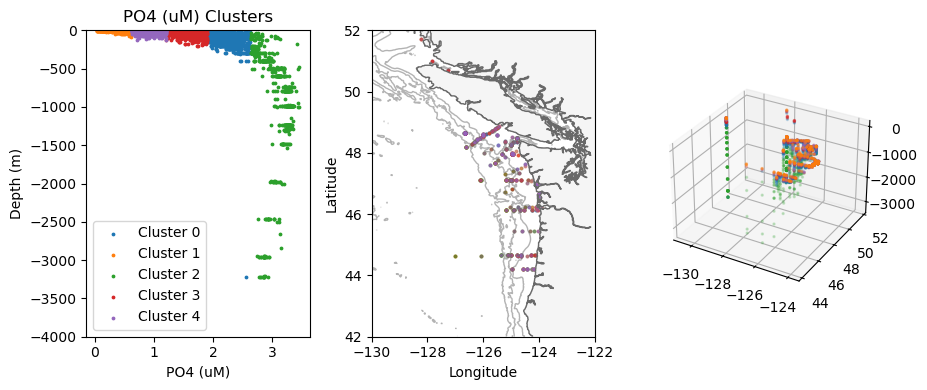

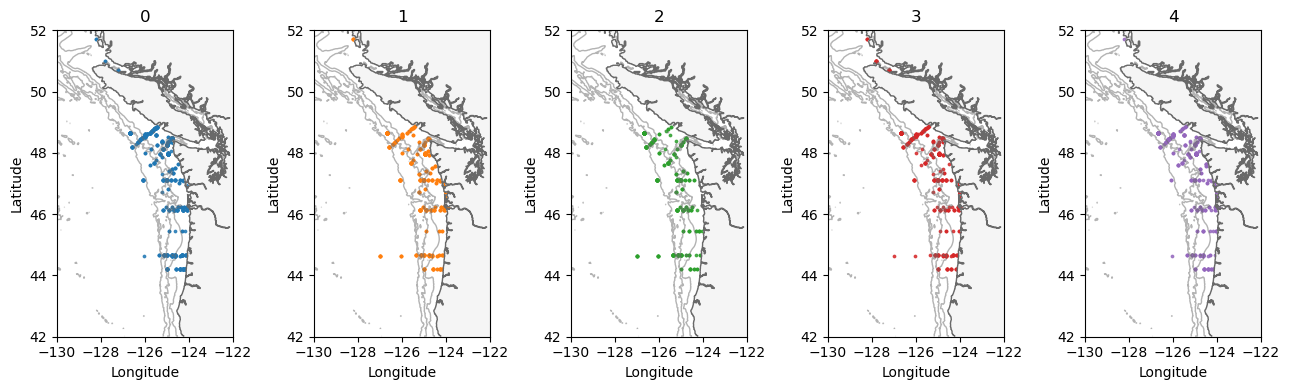

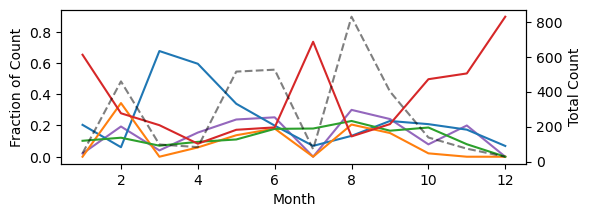

In [20]:
PO4cluster = cluster('PO4 (uM)')
cluster_plot(PO4cluster, "PO4 (uM)")

fig, ax = plt.subplots(1,5,figsize=[13,4])
for n in range(5):
    ind_cluster_plots(PO4cluster, n, ax[n], colours[n])

# should add plot that shows clusters in time versus depth
Cdata = PO4cluster
Cdata['month']=[Cdata.time[i].month for i in Cdata.index]

ntot = [len(Cdata[(Cdata.month==mo)]) for mo in np.arange(1,13)] # montly total count

fig,ax = plt.subplots(1,1,figsize=[6,2])
for k in range(len(Cdata['Cluster'].unique())):
    ax.plot(np.arange(1,13), [len(Cdata[(Cdata.Cluster==k) & (Cdata.month==mo)])/(ntot[mo-1]+1) for mo in np.arange(1,13)], c=colours[k-1])
ax2 = ax.twinx()
ax2.plot(np.arange(1,13),ntot,'k--',alpha=0.5)

ax2.set_ylabel('Total Count')
ax.set_xlabel('Month')
ax.set_ylabel('Fraction of Count')

Text(0, 0.5, 'Fraction of Count')

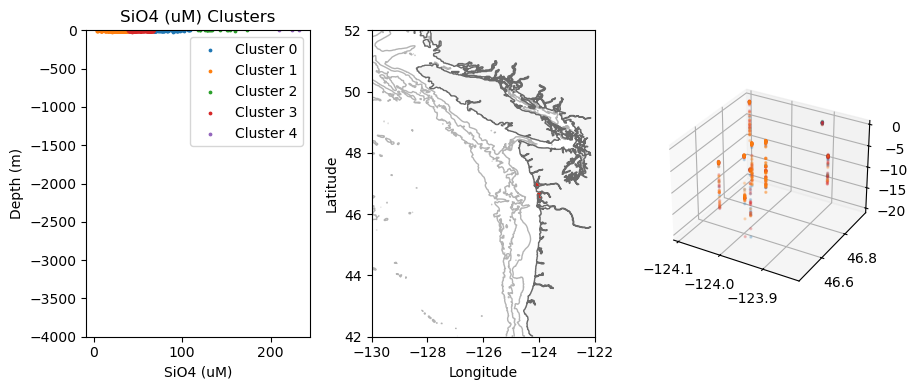

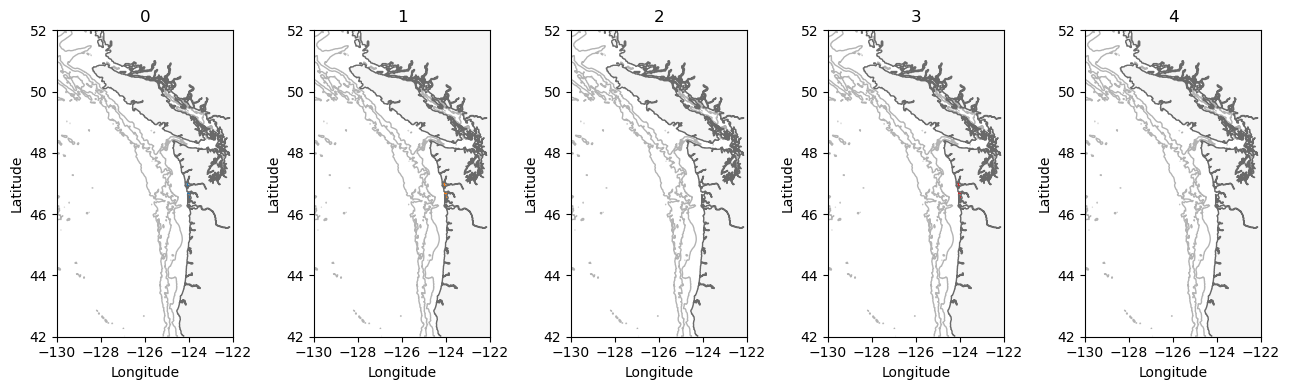

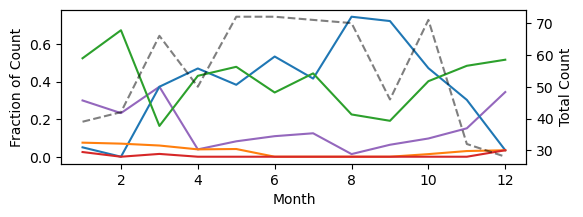

In [21]:
SiO4cluster = cluster('SiO4 (uM)')
cluster_plot(SiO4cluster, "SiO4 (uM)")

fig, ax = plt.subplots(1,5,figsize=[13,4])
for n in range(5):
    ind_cluster_plots(SiO4cluster, n, ax[n], colours[n])

# should add plot that shows clusters in time versus depth
Cdata = SiO4cluster
Cdata['month']=[Cdata.time[i].month for i in Cdata.index]

ntot = [len(Cdata[(Cdata.month==mo)]) for mo in np.arange(1,13)] # montly total count

fig,ax = plt.subplots(1,1,figsize=[6,2])
for k in range(len(Cdata['Cluster'].unique())):
    ax.plot(np.arange(1,13), [len(Cdata[(Cdata.Cluster==k) & (Cdata.month==mo)])/(ntot[mo-1]+1) for mo in np.arange(1,13)], c=colours[k-1])
ax2 = ax.twinx()
ax2.plot(np.arange(1,13),ntot,'k--',alpha=0.5)

ax2.set_ylabel('Total Count')
ax.set_xlabel('Month')
ax.set_ylabel('Fraction of Count')

Text(0, 0.5, 'Fraction of Count')

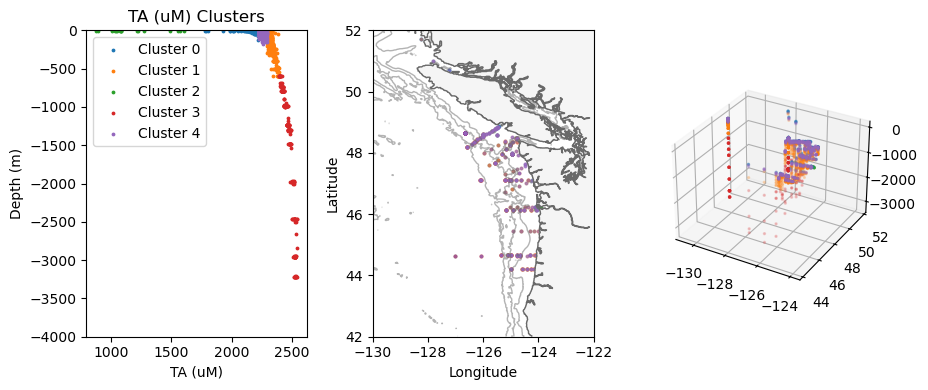

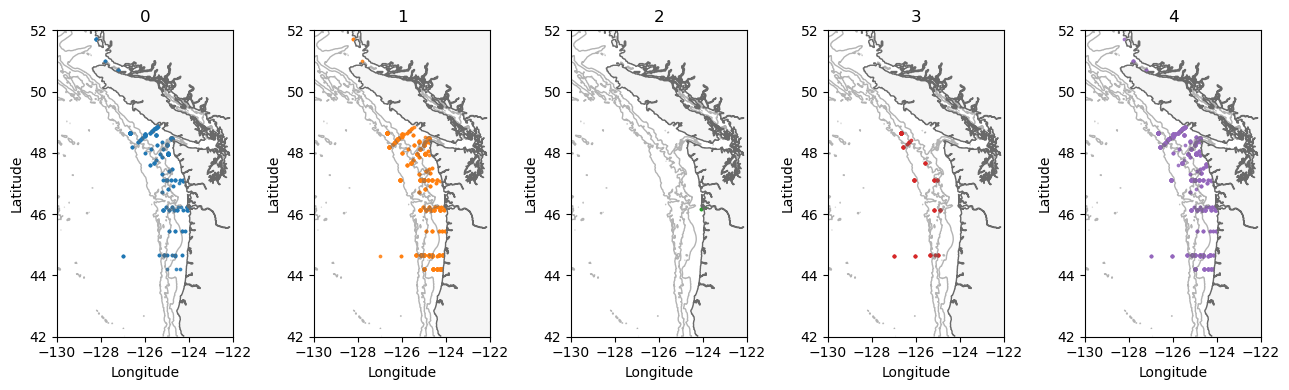

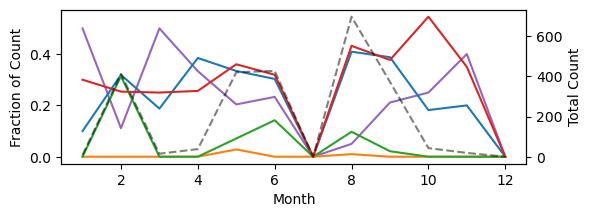

In [22]:
TAcluster = cluster('TA (uM)')
cluster_plot(TAcluster, "TA (uM)")

fig, ax = plt.subplots(1,5,figsize=[13,4])
for n in range(5):
    ind_cluster_plots(TAcluster, n, ax[n], colours[n])

# should add plot that shows clusters in time versus depth
Cdata = TAcluster
Cdata['month']=[Cdata.time[i].month for i in Cdata.index]

ntot = [len(Cdata[(Cdata.month==mo)]) for mo in np.arange(1,13)] # montly total count

fig,ax = plt.subplots(1,1,figsize=[6,2])
for k in range(len(Cdata['Cluster'].unique())):
    ax.plot(np.arange(1,13), [len(Cdata[(Cdata.Cluster==k) & (Cdata.month==mo)])/(ntot[mo-1]+1) for mo in np.arange(1,13)], c=colours[k-1])
ax2 = ax.twinx()
ax2.plot(np.arange(1,13),ntot,'k--',alpha=0.5)

ax2.set_ylabel('Total Count')
ax.set_xlabel('Month')
ax.set_ylabel('Fraction of Count')

Text(0, 0.5, 'Fraction of Count')

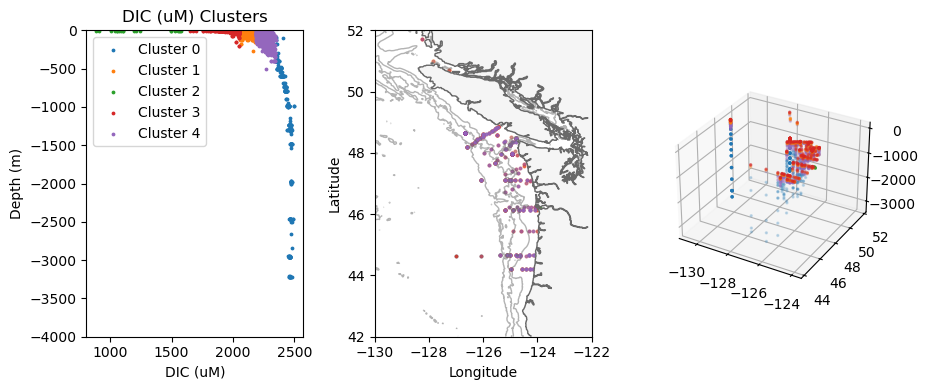

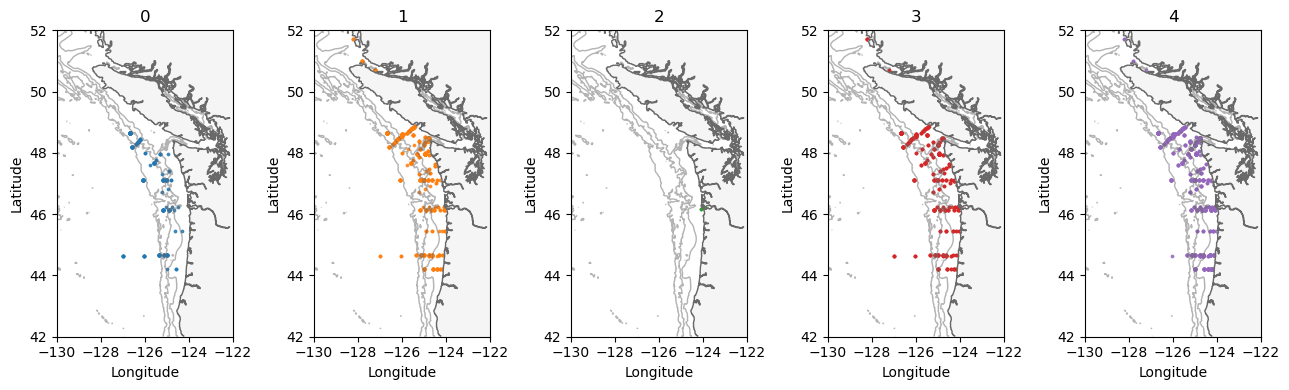

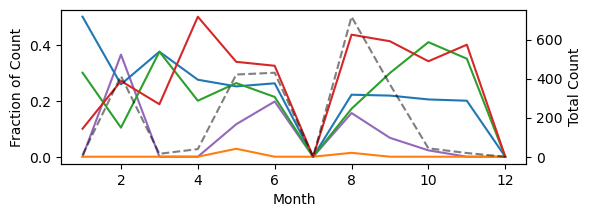

In [23]:
DICcluster = cluster('DIC (uM)')
cluster_plot(DICcluster, "DIC (uM)")

fig, ax = plt.subplots(1,5,figsize=[13,4])
for n in range(5):
    ind_cluster_plots(DICcluster, n, ax[n], colours[n])

# should add plot that shows clusters in time versus count (normalized by count)
Cdata = DICcluster
Cdata['month']=[Cdata.time[i].month for i in Cdata.index]

ntot = [len(Cdata[(Cdata.month==mo)]) for mo in np.arange(1,13)] # montly total count

fig,ax = plt.subplots(1,1,figsize=[6,2])
for k in range(len(Cdata['Cluster'].unique())):
    ax.plot(np.arange(1,13), [len(Cdata[(Cdata.Cluster==k) & (Cdata.month==mo)])/(ntot[mo-1]+1) for mo in np.arange(1,13)], c=colours[k-1])
ax2 = ax.twinx()
ax2.plot(np.arange(1,13),ntot,'k--',alpha=0.5)

ax2.set_ylabel('Total Count')
ax.set_xlabel('Month')
ax.set_ylabel('Fraction of Count')